# Counting Easter eggs
Our experiment compares the classification approach and the regression approach. The selection is done with the `class_mode` option in Keras' ImageDataGenerator flow_from_directory. `categorical` is used for the one-hot encoding and `sparse` for integers as classes.

Careful: While this is convention there, in other contexts, 'sparse' might mean a vector representation with more-than-one-hot entries, and rather the term 'binary' would be used for integers, generalizing a binary 0/1 problem to several possible classes.

In the notebook, the class_mode is used as a switch for the different Net variants and evaluation scripting.

In [1]:
class_mode = "categorical"

## Imports and version numbers

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import os
import re
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

In [3]:
# Python version: 3.8
print(tf.__version__)

2.3.1


In [4]:
# CUDA version:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:12:52_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.1, V10.1.243


## Prepare data for the training
If you redo this notebook on your own, you'll need the images with 0..7 (without 5) eggs in the folders `./images/0` ... `./images/7` (`./images/5` must exist for the classification training, but be empty)

In [5]:
data_directory = "./images"

input_shape = [64,64,3] # 256
batch_size = 16

seed = 123 # for val split

train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0/255.0
    )

train_generator = train_datagen.flow_from_directory(
    data_directory,
    seed=seed,
    target_size=(input_shape[0],input_shape[1]),
    color_mode="rgb",
    class_mode=class_mode,
    batch_size=batch_size,
    subset='training'
)

val_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0/255.0
    )
    
val_generator = val_datagen.flow_from_directory(
    data_directory,
    seed=seed,
    target_size=(input_shape[0],input_shape[1]),
    color_mode="rgb",
    class_mode=class_mode,
    batch_size=batch_size,
    subset='validation'
)


Found 11200 images belonging to 8 classes.
Found 2800 images belonging to 8 classes.


## Prepare the model

In [6]:

num_classes = 8 # because 0..7 eggs
if class_mode == "categorical":
    num_output_dimensions = num_classes
if class_mode == "sparse":
    num_output_dimensions = 1

model = tf.keras.Sequential()

model.add( tf.keras.layers.Conv2D(
    filters = 4,
    kernel_size = 5,
    strides = 1,
    padding = 'same',
    activation = 'relu',
    input_shape = input_shape
    ))
model.add( tf.keras.layers.MaxPooling2D(
    pool_size = 2, strides = 2
    ))
model.add( tf.keras.layers.Conv2D(
    filters = 8,
    kernel_size = 5,
    strides = 1,
    padding = 'same',
    activation = 'relu'
    ))
model.add( tf.keras.layers.MaxPooling2D(
    pool_size = 2, strides = 2
    ))
model.add( tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units = 16, activation = 'relu'
    ))
if class_mode == "categorical":
    last_activation = 'softmax'
if class_mode == "sparse":
    last_activation = None
model.add(tf.keras.layers.Dense(
    units = num_output_dimensions, activation = last_activation
    ))

if class_mode == "categorical":
    loss = 'categorical_crossentropy'
if class_mode == "sparse":
    loss = 'mse'
model.compile(
    optimizer = 'adam',
    loss = loss,
    metrics = ['accuracy']
    )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 4)         304       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         808       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                32784     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1

## Train the model
(on 0,1,2,3,4,6,7, but not 5 eggs)

In [7]:
epochs = 5

model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    )


Epoch 1/5
700/700 [==============================] - 29s 41ms/step - loss: 0.8835 - accuracy: 0.6392 - val_loss: 0.1543 - val_accuracy: 0.9654
Epoch 2/5
700/700 [==============================] - 29s 41ms/step - loss: 0.1501 - accuracy: 0.9516 - val_loss: 0.0663 - val_accuracy: 0.9804
Epoch 3/5
700/700 [==============================] - 29s 41ms/step - loss: 0.0836 - accuracy: 0.9729 - val_loss: 0.1199 - val_accuracy: 0.9543
Epoch 4/5
700/700 [==============================] - 29s 41ms/step - loss: 0.0766 - accuracy: 0.9739 - val_loss: 0.0389 - val_accuracy: 0.9907
Epoch 5/5
700/700 [==============================] - 29s 41ms/step - loss: 0.0638 - accuracy: 0.9797 - val_loss: 0.0628 - val_accuracy: 0.9754


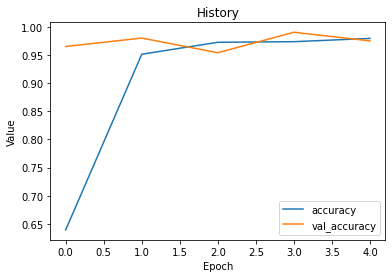

In [8]:
plt.figure()

if class_mode == "categorical":
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title('History')
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(['accuracy','val_accuracy'], loc='best')
    plt.show()

if class_mode == "sparse":
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.title('History')
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(['loss','val_loss'], loc='best')
    plt.show()

## Illustrate performance on unknown and completely unknown input
(5 eggs are completly unknown; all other numbers trained but at least the test image with 4 eggs was not used during training)

If you are running this notebook on you own, you might have to adjust the filepaths, and you'll have to put the images with 5 eggs in the folder `./images_other/5`

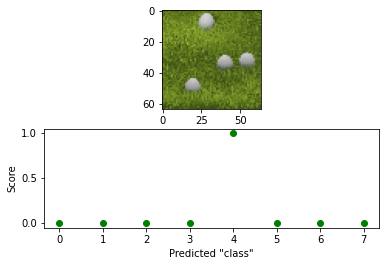

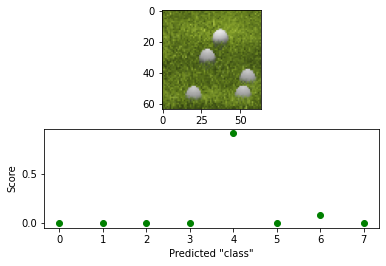

In [9]:
filepath_known = './images_known_unknown/4/0.png'
filepath_unknown = './images_unknown/5/0.png'

# helper function to make the notebook more tidy
def make_prediction(filepath):
    img = load_img(
        filepath,
        target_size=(input_shape[0],input_shape[1])
        )
    img = np.array(img)
    img = img / 255.0
    data = np.expand_dims(img, axis=0)
    prediction = model.predict(data)[0]
    predicted_class = np.argmax(prediction)
    return img, prediction, predicted_class

if class_mode == "categorical":
    img, prediction, predicted_class = make_prediction(filepath_known)

    plt.figure()
    plt.subplot(2,1,0+1)
    plt.imshow(img)
    plt.subplot(2,1,0+2)
    plt.plot(prediction,'og')
    plt.xlabel('Predicted "class"')
    plt.ylabel('Score')

    img, prediction, predicted_class = make_prediction(filepath_unknown)

    plt.figure()
    plt.subplot(2,1,0+1)
    plt.imshow(img)
    plt.subplot(2,1,0+2)
    plt.plot(prediction,'og')
    plt.xlabel('Predicted "class"')
    plt.ylabel('Score')

if class_mode == "sparse":
    img, prediction, predicted_class = make_prediction(filepath_known)

    plt.figure()
    plt.imshow(img)
    _ = plt.title('Prediction: '+str(prediction[0])+' - '+str(round(prediction[0])))

    img, prediction, predicted_class = make_prediction(filepath_unknown)

    plt.figure()
    plt.imshow(img)
    _ = plt.title('Prediction: '+str(prediction[0])+' - '+str(round(prediction[0])))

Found 2000 images belonging to 8 classes.
2000/2000 [==============================] - 5s 3ms/step


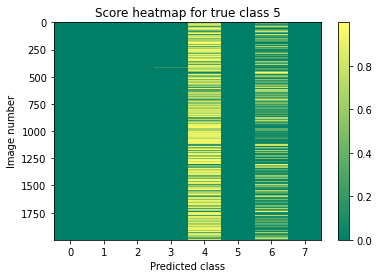

In [10]:
data_test_directory = "./images_unknown"

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
    )
test_generator = test_datagen.flow_from_directory(
    data_test_directory,
    target_size=(input_shape[0],input_shape[1]),
    color_mode="rgb",
    class_mode=class_mode,
    batch_size=1,
    subset=None,
    shuffle=False
    )

all_predictions = model.predict(test_generator, verbose=1)

plt.figure()

if class_mode == 'categorical':
    _ = plt.imshow(all_predictions, cmap='summer', aspect='auto', interpolation='none')
    _ = plt.colorbar()
    _ = plt.xlabel('Predicted class')
    _ = plt.ylabel('Image number')
    _ = plt.title('Score heatmap for true class 5')

if class_mode == 'sparse':
    num_bins = 70
    _ = plt.hist(all_predictions, num_bins, color='g')
    _ = plt.xlabel('Regression value')
    _ = plt.ylabel('Counts')
    _ = plt.title('Histogram of output values for true number 5')

## Illustrate performance on completely known data
For the sake of completeness, we repeat the last plots again for the known data used in the training phase.

Found 14000 images belonging to 8 classes.
14000/14000 [==============================] - 37s 3ms/step


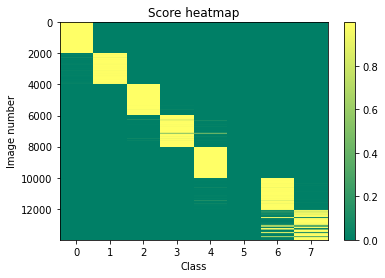

In [11]:
data_test_directory = "./images"

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
    )
test_generator = test_datagen.flow_from_directory(
    data_test_directory,
    target_size=(input_shape[0],input_shape[1]),
    color_mode="rgb",
    class_mode=class_mode,
    batch_size=1,
    subset=None,
    shuffle=False
    )

test_labels = (test_generator.class_indices)
test_filenames = test_generator.filenames

all_predictions = model.predict(test_generator, verbose=1)

if class_mode == "categorical":
    _ = plt.imshow(all_predictions, cmap='summer', aspect='auto', interpolation='none')
    _ = plt.colorbar()
    _ = plt.xlabel('Class')
    _ = plt.ylabel('Image number')
    _ = plt.title('Score heatmap')

if class_mode == "sparse":
    plt.figure()
    num_bins = 70
    _ = plt.hist(all_predictions, num_bins, color='g')
    _ = plt.xlabel('Regression value')
    _ = plt.ylabel('Counts')
    _ = plt.title('Histogram of output values')